# Querying Satellite Data

## ❓ Questions
-  Where can I find open-access satellite data?
-  How do I search for satellite imagery
-  How do I fetch remote raster datasets using Python?


## ❗ Objectives
-  Search public STAC repositories of satellite imagery using Python
-  Inspect search result’s metadata.
-  Download (a subset of) the assets available for a satellite scene.
-  Open satellite imagery as raster data and save it to disk.




---

# Introduction
A number of satellites take snapshots of the Earth’s surface from space. The images recorded by these remote sensors represent a very precious data source for any activity that involves monitoring changes on Earth. Satellite imagery is typically provided in the form of geospatial raster data, with the measurements in each grid cell (“pixel”) being associated to accurate geographic coordinate information.

In this lesson we will explore how to access open satellite data using Python. In particular, we will consider the Sentinel-2 data collections hosted at SARA and AWS. This dataset consists of multi-band optical images acquired by the two satellites of the Sentinel-2 mission and it is continuously updated with new images.

## API's
An API is an Application Programming Interface.   

It is a way of having one application talk (interface) with another application in a pre-defined way. For what we're doing, these will be using web addresses and JSON data, and will be handled by our library, EODAG.   

We will:
1. First initialise EODAG 
2. Give it the information it needs
3. Ask it to send send the request
EODAG will
4. receive the information, and 
5. interpret it for us.

A useful resource will be the [EODAG documentation on searching](https://eodag.readthedocs.io/en/stable/notebooks/api_user_guide/4_search.html).


# Authenticating

In [78]:
import os
from getpass import getpass
workspace = './workshop_data'
os.environ["EODAG__SARA__AUTH__CREDENTIALS__USERNAME"] = "leigh.tyers@curtin.edu.au"
os.environ["EODAG__SARA__AUTH__CREDENTIALS__PASSWORD"] = getpass("Enter Password")
os.environ["EODAG__SARA__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)

# Initialising EODAG

In [79]:
from eodag import EODataAccessGateway
from eodag import setup_logging
setup_logging(2)

dag = EODataAccessGateway()
dag.set_preferred_provider("sara")

2024-06-12 12:52:18,635 eodag.config                     [INFO    ] Loading user configuration from: /home/ubuntu/.config/eodag/eodag.yml
2024-06-12 12:52:18,659 eodag.core                       [INFO    ] usgs: provider needing auth for search has been pruned because no crendentials could be found
2024-06-12 12:52:18,659 eodag.core                       [INFO    ] aws_eos: provider needing auth for search has been pruned because no crendentials could be found
2024-06-12 12:52:18,660 eodag.core                       [INFO    ] meteoblue: provider needing auth for search has been pruned because no crendentials could be found
2024-06-12 12:52:18,660 eodag.core                       [INFO    ] hydroweb_next: provider needing auth for search has been pruned because no crendentials could be found
2024-06-12 12:52:18,660 eodag.core                       [INFO    ] wekeo: provider needing auth for search has been pruned because no crendentials could be found
2024-06-12 12:52:18,661 eodag.core

# Exploring EODAG

In [80]:
# List sara products
dag.list_product_types("sara")

[{'ID': 'S1_SAR_GRD', 'abstract': 'Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and\nprojected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has\napproximately square spatial resolution pixels and square pixel spacing with reduced speckle at the cost of worse\nspatial resolution.\nGRD products can be in one of three resolutions: |\n  Full Resolution (FR),\n  High Resolution (HR),\n  Medium Resolution (MR).\nThe resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR\nand HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.\nSAFE formatted product, see\nhttps://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/data-formats/safe-specification\n', 'instrument': 'SAR', 'platform': 'SENTINEL1', 'platformSerialIdentifier': 'S1A,S1B', 'processingLevel': 'L1', 'keywords': 'SAR,SENTINEL,SENTINEL1,S1,S1A,S

In [81]:
# List available product types of S2 L2A (S2_MSI_L2A)
dag.available_providers("S2_MSI_L2A")

['astraea_eod', 'cop_dataspace', 'creodias', 'onda', 'planetary_computer', 'sara']

## Search Criteria
We're going to use an advanced feature of python and set our search criteria out in advance with a dictionary

In [260]:
lonmin = 116.2
lonmax = 116.5
latmin = -31.5
latmax = -32

default_search_criteria = {
    "productType": "S2_MSI_L2A",
    "start": "2023-08-24",
    "end": "2023-08-26",
    "geom": {"lonmin": lonmin,  "lonmax": lonmax, "latmin": latmin, "latmax": latmax},
    #"cloudCover": 15 # CC < 15
}

# Pagination - A common pitfall
When doing a web-search, one does not get all two billion possible results sent to them. This would not only take a long time to be sent, but most of these would never be used. To alleviate this, most services (such as google bing, twitter, facebook etc) use a technique called `pagination`. While you used to get about 10-20 results per page and had to click next page, now if as you scroll down a page, you look at the side bar, you will see it move up and get smaller now and again.   

This is because your web-browser understands it's nearing the end of what's available, and sends a request to the website for more information. The website then sends the next 'page'.   

The web-based API's we use will also send us a page at a time. Usually they can let us tell them how long a page should be, up to a maximum.    
If you're an advanced user and care about latency, you may want to load a page at a time, in which case use the `dag.search()` function (refer to the documentation).  

If you dont care, and just want all the results like we do, use the `dag.search_all()` function.


In [261]:
all_products = dag.search_all(**default_search_criteria) 
all_products

2024-06-12 16:05:49,420 eodag.core                       [INFO    ] Searching product type 'S2_MSI_L2A' on provider: sara
2024-06-12 16:05:49,422 eodag.core                       [INFO    ] Iterate search over multiple pages: page #1
2024-06-12 16:05:49,422 eodag.search.qssearch            [INFO    ] Sending search request: https://copernicus.nci.org.au/sara.server/1.0/api/collections/S2/search.json?startDate=2023-08-24&completionDate=2023-08-26&geometry=POLYGON ((116.2000 -31.5000, 116.2000 -32.0000, 116.5000 -32.0000, 116.5000 -31.5000, 116.2000 -31.5000))&productType=S2MSIL2A&instrument=MSI&processingLevel=L2A&maxRecords=500&page=1
2024-06-12 16:05:49,755 eodag.core                       [INFO    ] Found 2 result(s) on provider 'sara'


[EOProduct(id=S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459, provider=sara), EOProduct(id=S2A_MSIL2A_20230824T021351_N0509_R060_T50JML_20230824T070459, provider=sara)]

## Exploring the results
Let's open up the results and explore them

In [262]:
product = all_products[0]
product

EOProduct(id=S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459, provider=sara)

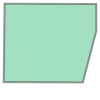

In [263]:
# geometry, geometry.bounds, geometry exterio coords xy....
all_products[0].geometry

In [264]:
# A few other key pieces of info
product.provider, product.product_type, product.search_kwargs

('sara', 'S2_MSI_L2A', {'auth': GenericAuth(provider=sara, priority=2, topic=Authentication), 'productType': 'S2_MSI_L2A', 'startTimeFromAscendingNode': '2023-08-24', 'completionTimeFromAscendingNode': '2023-08-26', 'geometry': <POLYGON ((116.2 -31.5, 116.2 -32, 116.5 -32, 116.5 -31.5, 116.2 -31.5))>})

In [265]:
# Use pretty print (pprint) to print out the properties
from pprint import pprint

pprint(product.properties)

{'abstract': None,
 'accessConstraint': {'description': {'shortName': 'No license'},
                      'grantedCountries': None,
                      'grantedFlags': None,
                      'grantedOrganizationCountries': None,
                      'hasToBeSigned': 'never',
                      'licenseId': 'unlicensed',
                      'signatureQuota': -1,
                      'viewService': 'public'},
 'centroid': {'coordinates': [116.51847894386, -32.12776485969],
              'type': 'Point'},
 'cloudCover': 2,
 'completionTimeFromAscendingNode': '2023-08-24T02:13:51.024Z',
 'downloadLink': 'https://copernicus.nci.org.au/sara.server/1.0/collections/S2/4f4dc41e-45d0-5f37-a118-2eb90c439776/download',
 'id': 'S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459',
 'instrument': 'MSI',
 'keyword': [{'href': 'https://copernicus.nci.org.au/sara.server/1.0/api/collections/S2/search.json?&lang=en&q=Oceania',
              'id': '62f4365c66c1f64',
              '

# Viewing thumbnails
One of the product properties is the 'thumbnail'. These are smaller versions of the entire image to quickly identify any issues, before download

Let's view these for each of the products. For this, we will use a library called matplotlib.

0.00B [00:00, ?B/s]

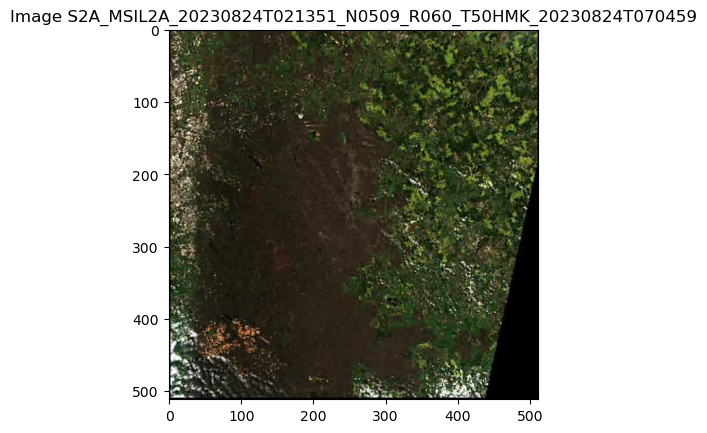

0.00B [00:00, ?B/s]

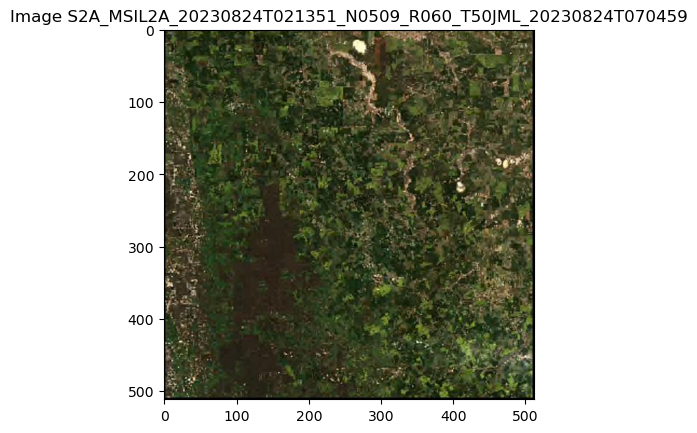

In [267]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for product in all_products:
    quicklook_path = product.get_quicklook()
    img = mpimg.imread(quicklook_path)
    plt.imshow(img)
    plt.title(f"Image {product.properties['title']}")
    plt.show()

# Folium
Folium is a great library for visualising 

In [268]:
import folium

In [269]:
geometry = default_search_criteria["geom"]
geometry

{'lonmin': 116.2, 'lonmax': 116.5, 'latmin': -31.5, 'latmax': -32}

In [270]:
# Create a map zoomed over the search area
fmap = folium.Map(location=[(latmin + latmax)/2, (lonmin + lonmax)/2], zoom_start=7)

# Add a GeoJson of the Search Results
folium.GeoJson(
    data=all_products,  # SearchResult has a __geo_interface__ interface used by folium to get its GeoJSON representation
    tooltip=folium.GeoJsonTooltip(fields=["title"])
).add_to(fmap)

# Add a Rectangle of our search
folium.Rectangle(
    bounds=[[latmin, lonmin], [latmax, lonmax]],
    color="red",
    tooltip="Search extent"
).add_to(fmap)

fmap

# Authentication & Downloading from Thredds
If you have issues with authentication from AusCopHub, you can download straight from the same repository at NCI's THREDDS Dataserver

In [271]:
pprint(product.properties)

{'abstract': None,
 'accessConstraint': {'description': {'shortName': 'No license'},
                      'grantedCountries': None,
                      'grantedFlags': None,
                      'grantedOrganizationCountries': None,
                      'hasToBeSigned': 'never',
                      'licenseId': 'unlicensed',
                      'signatureQuota': -1,
                      'viewService': 'public'},
 'centroid': {'coordinates': [116.52356607, -31.225762067166], 'type': 'Point'},
 'cloudCover': 4,
 'completionTimeFromAscendingNode': '2023-08-24T02:13:51.024Z',
 'downloadLink': 'https://copernicus.nci.org.au/sara.server/1.0/collections/S2/00f59244-7389-5738-9c54-39d589e6192f/download',
 'id': 'S2A_MSIL2A_20230824T021351_N0509_R060_T50JML_20230824T070459',
 'instrument': 'MSI',
 'keyword': [{'href': 'https://copernicus.nci.org.au/sara.server/1.0/api/collections/S2/search.json?&lang=en&q=Oceania',
              'id': '62f4365c66c1f64',
              'name': 'Oceania'

## Download
Now that we have queried available files, let's download one of the files.

In [281]:
file_downloaded = all_products[0].download()


0.00B [00:00, ?B/s]

2024-06-12 17:45:06,230 eodag.download.base              [INFO    ] Download url: https://copernicus.nci.org.au/sara.server/1.0/collections/S2/4f4dc41e-45d0-5f37-a118-2eb90c439776/download
2024-06-12 17:46:28,139 eodag.download.base              [INFO    ] Extraction activated
2024-06-12 17:46:30,290 eodag.download.base              [INFO    ] Deleting archive S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.zip
2024-06-12 17:46:30,412 eodag.product                    [INFO    ] Remote location of the product is still available through its 'remote_location' property: https://copernicus.nci.org.au/sara.server/1.0/collections/S2/4f4dc41e-45d0-5f37-a118-2eb90c439776/download


In [ ]:
from nci_downloader import download_product_thredds
file_list = []

file_downloaded = download_product_thredds(all_products[0], './data')


## Storing our downloaded filenames for future notebooks
Let's now store the file we downloaded in a text file for future use

In [284]:
product_directory = file_downloaded
dir_text_filename = "product_dir.txt"

with open(dir_text_filename, 'w') as f:
    f.writelines(product_directory)

# Other options
Another valid choice for downloading satellite data using python is [pystac-client.](https://pystac-client.readthedocs.io/en/latest/quickstart.html). 

Pystac takes a bit more knowhow of API's to use, but gives you more freedom as well.  
Pystac also supports COGs, which are currently only supported by the bleeding edge eodag-cube library rather than eodag itself.  
SARA and NCI (the locations we're getting satellite data from for this workshop) supply Sentinel-2 data as zip-files rather than COGs, hence we chose to simply use EODAG for this lesson.